In [1]:
!pip install annoy tensorflow faiss

### Prepare the dataset

In [2]:
import numpy as np
from tensorflow import keras

# Load the data and split it between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

print(x_train.shape)

mnist = x_train.reshape(60000, 28*28)
mnist.shape

(60000, 28, 28)


(60000, 784)

### Test the index

In [3]:
import time
from annoy import AnnoyIndex
import faiss

faiss.omp_set_num_threads(1)

In [4]:
index = AnnoyIndex(f=mnist.shape[1], metric='euclidean')

for i in range(mnist.shape[0]):
    index.add_item(i, vector=mnist[i, :])

index.build(n_trees=100)

I = index.get_nns_by_vector(vector=mnist[0], n=100)
print(I)

flat = faiss.IndexFlatL2(mnist.shape[1])
flat.add(mnist)

D, FLAT_I = flat.search(mnist[0].reshape(1, mnist.shape[1]), k=100) 
print(FLAT_I)

[0, 32248, 8728, 18932, 30483, 24149, 42338, 52295, 26251, 50173, 53634, 24330, 54159, 57528, 1482, 53428, 18123, 31379, 52864, 10536, 29719, 36087, 30489, 23947, 20034, 52057, 33825, 31008, 22477, 47968, 54203, 19825, 1634, 27378, 33909, 15378, 24708, 34474, 26413, 16017, 46824, 46358, 1516, 34557, 16832, 21629, 29021, 10740, 24107, 5688, 52665, 1864, 5036, 39031, 1978, 40546, 52231, 24730, 21976, 36697, 25675, 54189, 11396, 42555, 33445, 52540, 44263, 19186, 24232, 54184, 14736, 33970, 5210, 59212, 8642, 22569, 15052, 2933, 6772, 22963, 6516, 832, 21244, 21583, 35838, 59846, 21210, 13502, 52559, 13862, 41980, 43997, 53812, 18162, 13193, 46698, 46968, 50187, 3188, 28384]
[[    0 32248  8728 18932 30483 24149 42338 52295 26251 50173 53634 24330
  54159 57528  1482 53428 18123 31379 52864 10536 29719 36087 30489 23947
  20034 52057 33825 21654 31008 55208 22477 44282 47968 54203 19825  1634
  27378 33909 15378 24708 34474 26413 16017 46824 46358  1516 34557 16832
  21629 29021 10740 241

In [5]:
# Calculate the recall

sum([1 for i in I if i in FLAT_I]) / FLAT_I.size

0.9

In [6]:
import os 
import numpy as np

if not os.path.exists("save"):
    os.makedirs("save")


# index.save('save/t-100.ann')
np.save('save/mnist.npy', mnist)

In [7]:
from faiss import write_index
write_index(flat, 'save/flat.index')

### Benchmark 

In [8]:
import time 

tree_nums = [1, 10, 30, 50, 70, 90, 110, 130]
indexes=[]
build_time=[]

def build_index(data, n_trees, metric='euclidean'):
    index = AnnoyIndex(f=data.shape[1], metric='euclidean')
    for i in range(data.shape[0]):
        index.add_item(i, vector=data[i, :])

    index.build(n_trees)
    return index

for t_num in tree_nums:
    start = time.time()
    index = build_index(mnist, n_trees=t_num)
    btime = time.time() - start
    build_time.append(btime)
    indexes.append(index)
    
print(build_time)

[3.754587411880493, 3.936432361602783, 5.056959629058838, 7.146753549575806, 7.7451770305633545, 9.334761381149292, 11.344036340713501, 12.868558883666992]


In [9]:
def recall(pred, true):
    return sum([1 for i in pred if i in true]) / true.size

def benchmark_knn_query(data, indexes, size=1000, k=100):
    result = []

    indices = np.random.choice(data.shape[0], size, replace=False)
    for index in indexes:
        query_time = 0
        cur_recall = 0

        # query
        for i in indices:
            start = time.time()
            qk = index.get_nns_by_vector(vector=data[i], n=k)
            query_time += (time.time() - start)
            D, FLAT_I = flat.search(data[i].reshape(1, data.shape[1]), k=k) 
            cur_recall += recall(qk, FLAT_I)
        
        result.append((query_time/1000, cur_recall/1000))

    return result


result = benchmark_knn_query(mnist, indexes) 
print(result)     

[(0.0005792021751403808, 0.4000699999999997), (0.0010847818851470947, 0.7494000000000017), (0.001982557535171509, 0.917800000000004), (0.002742526054382324, 0.9571700000000033), (0.003198955774307251, 0.9713600000000034), (0.003629826545715332, 0.9782000000000027), (0.004008151292800903, 0.9826800000000023), (0.004355839252471924, 0.9857300000000022)]


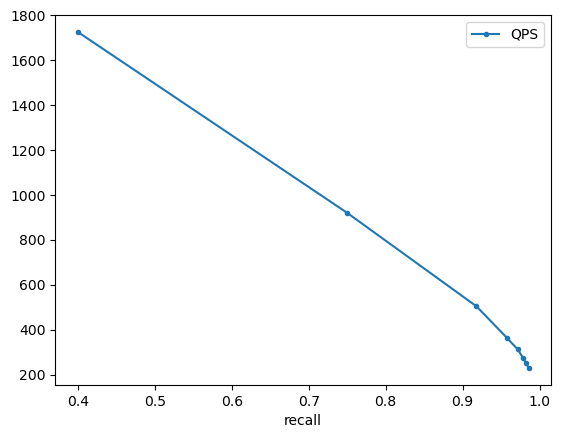

In [10]:
import pandas as pd

df = pd.DataFrame(result, columns=['query_time', 'recall'])
df['QPS'] = 1 / df['query_time']
df.plot(x='recall', y='QPS',style='.-')

import os  
os.makedirs('results', exist_ok=True)
df.to_csv('results/annoy-mnist.csv')